Objectives: 

- Look at a modelised song: sound, spectral derivative, feature values 

- Look at Boari et al. synthesized song: sound spectral derivative, feature values

- Compute error of the modelised song and the Boari synthesized song


# Imports

In [1]:
# Fixed plots
%matplotlib inline
# Dynamic plots
# %matplotlib notebook

import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import sys
import math
import copy
from os.path import join
import pickle
import pandas

import birdsonganalysis as bsa
import utils

sys.path.append('../model/')
from synth import synthesize
from measures import bsa_measure, normalize_and_center
from song_model import SongModel

np.set_printoptions(precision=3)

fig_width = 10 # full screen: 16 / half screen: 10
fig_height = 5

# Function and variable definitions

In [2]:
# g and c are outputs from the bsa_measure function
error_measure = lambda g, c: np.linalg.norm(g - c)

In [3]:
# Generation of the 3 songs: tutor, synthesized, song from the model
song_name = "boari_short"

sr, tutor = wavfile.read('../data/{}.wav'.format(song_name))
tutor = normalize_and_center(tutor)

# synth is already NORMALIZED
sr, synth_song = wavfile.read('../data/{}_out.wav'.format(song_name))

# A song model from a simulation
path = "../model/res/512_neg_beta_no_pitch_fast_180704_162942"
with open(join(path, "data.pkl"), "rb") as f:
    songlog = pickle.load(f)
    
root_data = [item[1] for item in songlog if item[0] == 'root']
rd = pandas.DataFrame(root_data)
best = np.argmin(rd['scores'].iloc[-1])
smodel = rd['songs'].iloc[-1][best]
song = smodel.gen_sound()

# Sound waves and spectral derivatives 

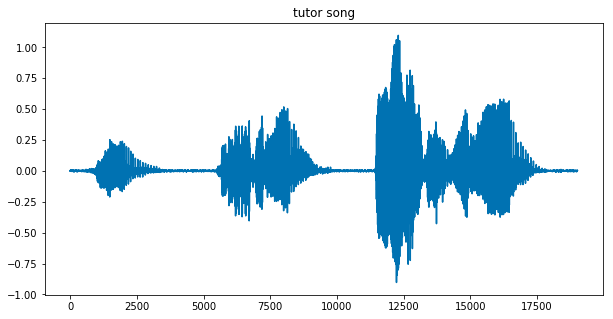

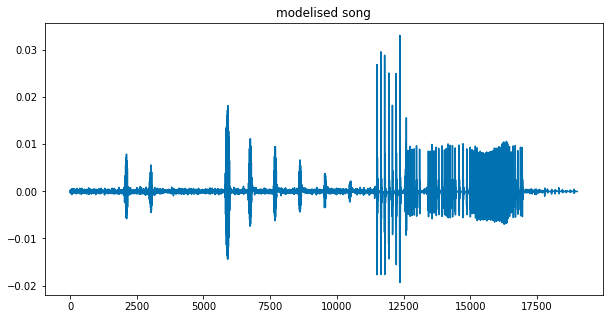

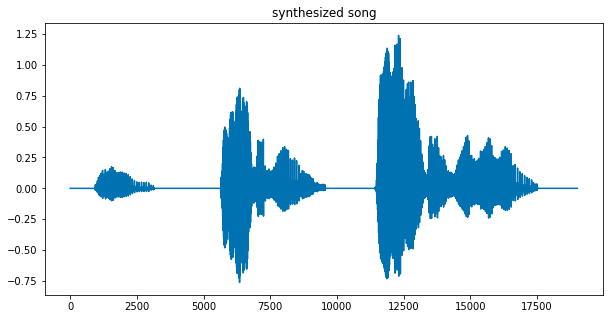

In [4]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(tutor)
plt.title("tutor song")
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(song)
plt.title("modelised song")
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(synth_song)
plt.title("synthesized song")
plt.show()

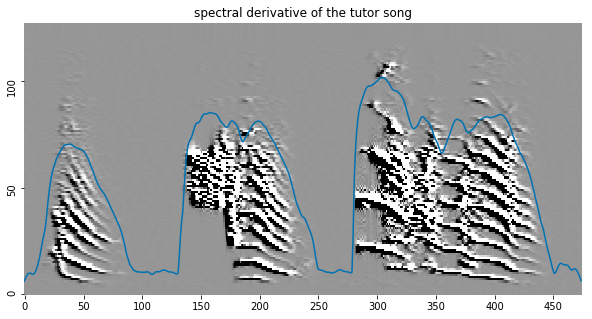

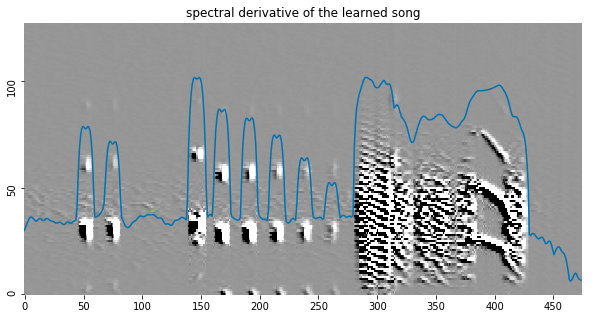

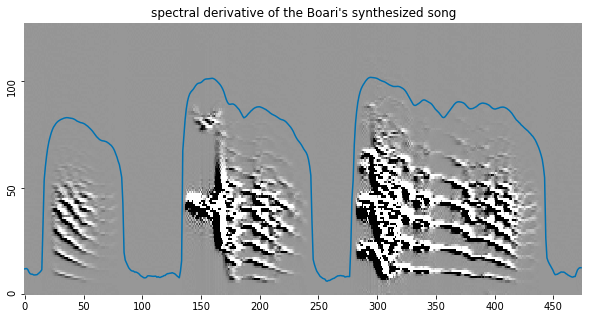

In [5]:
zoom = bsa.FFT_SIZE / bsa.FREQ_RANGE / 4

tutor_spec = bsa.spectral_derivs(tutor,
                                 bsa.FREQ_RANGE,
                                 bsa.FFT_STEP,
                                 bsa.FFT_SIZE)
song_spec = bsa.spectral_derivs(song,
                                bsa.FREQ_RANGE,
                                bsa.FFT_STEP,
                                bsa.FFT_SIZE)
synth_spec = bsa.spectral_derivs(synth_song,
                                 bsa.FREQ_RANGE,
                                 bsa.FFT_STEP,
                                 bsa.FFT_SIZE)

# Spectral derivative of the tutor song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(tutor_spec, contrast=0.01, ax=ax,
                         freq_range=bsa.FREQ_RANGE)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 
                                      bsa.FREQ_RANGE,
                                      bsa.FFT_STEP,
                                      bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plt.title("spectral derivative of the tutor song")
plt.show(fig)

# Spectral derivative of the learned song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(song_spec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(song,
                                      bsa.FREQ_RANGE,
                                      bsa.FFT_STEP,
                                      bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plt.title("spectral derivative of the learned song")
plt.show(fig)

# Spectral derivative of the Boari's synthesized song
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.gca()
bsa.spectral_derivs_plot(synth_spec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(synth_song,
                                      bsa.FREQ_RANGE,
                                      bsa.FFT_STEP,
                                      bsa.FFT_SIZE),
                   ax=ax, zoom=zoom)
ax.set_ylim(0, bsa.FREQ_RANGE * zoom)
plt.title("spectral derivative of the Boari's synthesized song")
plt.show(fig)

# bsa_measure function step by step

# Features dict

In [6]:
tutor_feat = bsa.all_song_features(tutor, bsa.SR,
                                   freq_range=bsa.FREQ_RANGE,
                                   fft_size=bsa.FFT_SIZE,
                                   fft_step=bsa.FFT_STEP)
synth_feat = bsa.all_song_features(synth_song, bsa.SR,
                                   freq_range=bsa.FREQ_RANGE,
                                   fft_size=bsa.FFT_SIZE,
                                   fft_step=bsa.FFT_STEP)
song_feat = bsa.all_song_features(song, bsa.SR,
                                   freq_range=bsa.FREQ_RANGE,
                                   fft_size=bsa.FFT_SIZE,
                                   fft_step=bsa.FFT_STEP)

p_feat = copy.deepcopy(tutor_feat)
tutor_feat = bsa.rescaling_with_tutor_values(p_feat, tutor_feat)

synth_feat = bsa.rescaling_with_tutor_values(p_feat, synth_feat)

song_feat = bsa.rescaling_with_tutor_values(p_feat, song_feat)

# Plots of features evolution during the song

In [7]:
fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude', 'pitch']

In [8]:
# gtes = np.loadtxt('../data/{}_gte.dat'.format(song_name))
# true_gtes = gtes[np.concatenate(((np.diff(gtes) > 100), (False,)))]

# Rescaling normalization

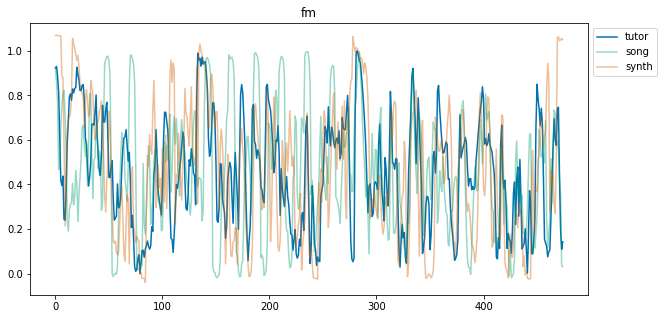

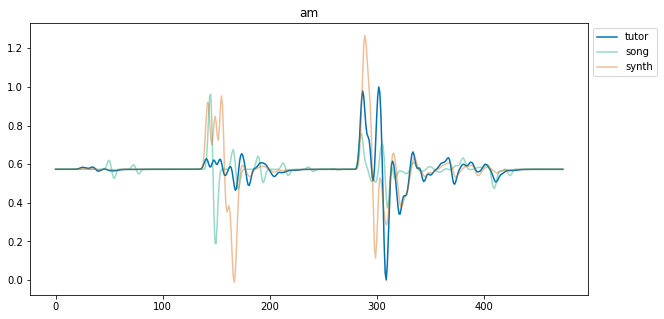

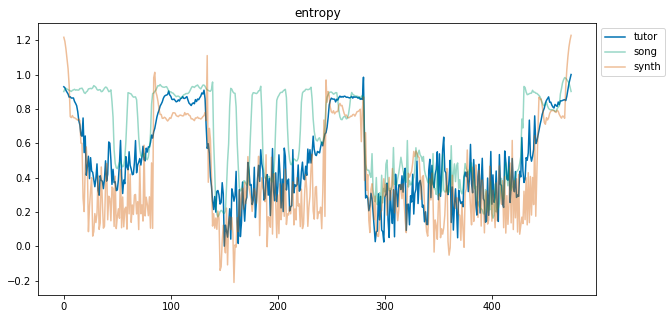

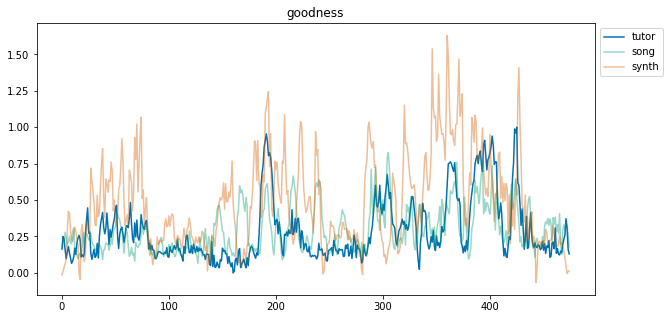

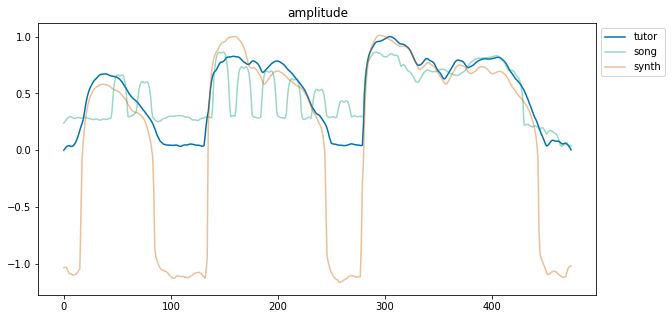

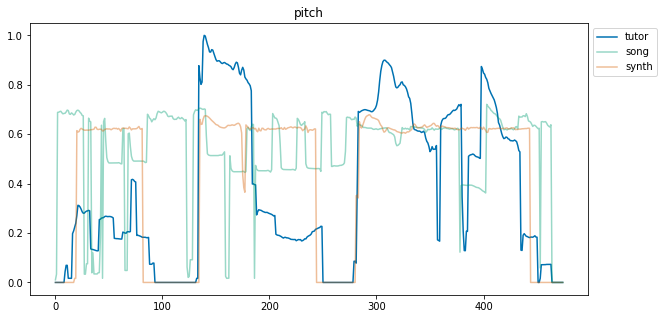

In [9]:
for feat in fnames:
    plt.figure(figsize=(fig_width, fig_height))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# Contribution of each feature (in a vector) in the error calculation

# Error calculations

In [10]:
coefs_list = [{"fm": 0, "am": 0, "entropy": 1,
               "goodness": 0, "amplitude": 1, "pitch": 0},
              {"fm": 1, "am": 0, "entropy": 1,
               "goodness": 0, "amplitude": 1, "pitch": 0},
              {"fm": 1, "am": 1, "entropy": 1,
               "goodness": 1, "amplitude": 1, "pitch": 1},
              {"fm": 1, "am": 1, "entropy": 5,
               "goodness": 1, "amplitude": 5, "pitch": 1},
              {"fm": 5, "am": 1, "entropy": 5,
               "goodness": 1, "amplitude": 5, "pitch": 1}]

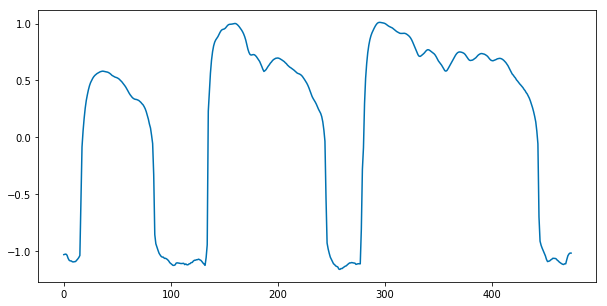

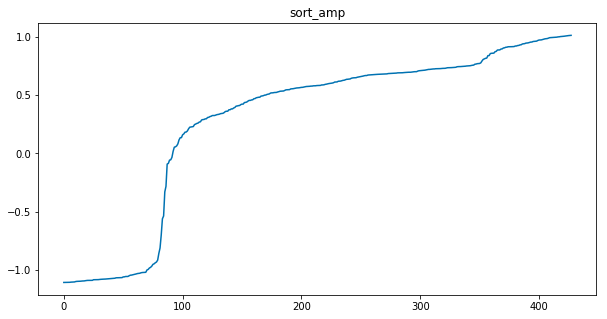

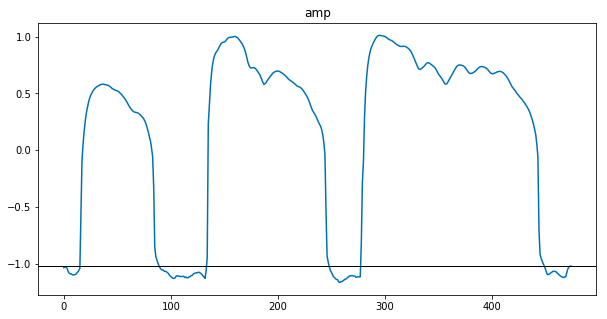

threshold: -1.0192144792730786

fm: 0 / am: 0 / entropy: 1 / goodness: 0 / amplitude: 1 / pitch: 0
Boari err per feat:
synth: 	fm: 0.0	am: 0.0	entropy: 18.105	goodness: 0.0	amplitude: 20.07	pitch: 0.0
song: 	fm: 0.0	am: 0.0	entropy: 29.66	goodness: 0.0	amplitude: 20.252	pitch: 0.0

Boari synth error: 8.19781352530126
Modelised song error: 7.064802530483184

Delta: -1.1330109948180764

fm: 1 / am: 0 / entropy: 1 / goodness: 0 / amplitude: 1 / pitch: 0
Boari err per feat:
synth: 	fm: 20.79	am: 0.0	entropy: 18.105	goodness: 0.0	amplitude: 20.07	pitch: 0.0
song: 	fm: 42.83	am: 0.0	entropy: 29.66	goodness: 0.0	amplitude: 20.252	pitch: 0.0

Boari synth error: 10.188396515332744
Modelised song error: 9.630258942266707

Delta: -0.5581375730660376

fm: 1 / am: 1 / entropy: 1 / goodness: 1 / amplitude: 1 / pitch: 1
Boari err per feat:
synth: 	fm: 20.79	am: 5.427	entropy: 18.105	goodness: 53.949	amplitude: 20.07	pitch: 30.075
song: 	fm: 42.83	am: 3.459	entropy: 29.66	goodness: 15.608	amplitude: 2

In [11]:
######################################################################
# Details of utils.carac_to_calculate_err_of_synth funtion
amp = bsa.song_amplitude(synth_song, 
                         bsa.FREQ_RANGE, 
                         bsa.FFT_STEP, 
                         bsa.FFT_SIZE)
amp = bsa.rescaling_one_feature(p_feat['amplitude'], amp)
plt.figure(figsize=(fig_width, fig_height))
plt.plot(amp)
plt.show()
sort_amp = np.sort(amp)
sort_amp = sort_amp[len(sort_amp)//10:]
plt.figure(figsize=(fig_width, fig_height))
plt.plot(sort_amp)
plt.title('sort_amp')
plt.show()
i_max_diff = np.argmax(utils._running_mean(np.diff(sort_amp), 100))
th = sort_amp[i_max_diff]
plt.figure(figsize=(fig_width, fig_height))
plt.plot(amp)
plt.axhline(y=th, color="k", linewidth=1)
plt.title('amp')
plt.show()
print("threshold:", th)
print()
######################################################################

for coefs in coefs_list:
    string = ""
    string += "fm: {} / ".format(coefs["fm"])
    string += "am: {} / ".format(coefs["am"])
    string += "entropy: {} / ".format(coefs["entropy"])
    string += "goodness: {} / ".format(coefs["goodness"])
    string += "amplitude: {} / ".format(coefs["amplitude"])
    string += "pitch: {}".format(coefs["pitch"])
    print(string)
    
    mtutor = bsa_measure(tutor, bsa.SR, coefs, p_feat)
    msynth = bsa_measure(synth_song, bsa.SR, coefs, p_feat)
    msong = bsa_measure(song, bsa.SR, coefs, p_feat)
    
    err_feat_vect = utils.err_per_feat(mtutor, msong)
    err_per_feat_synth = utils.err_per_feat(mtutor[amp > th],
                                            msynth[amp > th])
    
    synth_err = utils.boari_synth_song_error(tutor,
                                             synth_song,
                                             coefs,
                                             p_feat)
    song_err = error_measure(mtutor, msong)
    
    print("Boari err per feat:")
    str_synth = "synth: "
    str_song = "song: "
    for i in range(len(fnames)):
        str_synth += "\t{}: {}".format(fnames[i],
                                       round(err_per_feat_synth[i],3))
        str_song += "\t{}: {}".format(fnames[i],
                                      round(err_feat_vect[i],3))
    print(str_synth)
    print(str_song)
    print()
    print("Boari synth error:", synth_err)
    print("Modelised song error:", song_err)
    print()
    print("Delta:", song_err - synth_err)
    print()